In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
import torch.optim as optim
import optuna
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 18})

c:\Users\14390\.conda\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
features = np.load(f'DataSet/Features_Diff_1.npz')['Features_Diff_1']
print(features.shape)

(151839, 71, 8)


In [3]:
data = features[0:90000]

In [4]:
input_window = 47
output_window = 24

# 用来存储输入和输出的列表
inputs = []
outputs = []

# 为了确保没有超出数组的界限，我们创建一个循环，截止到可以完整提取一个输入加一个输出的位置
for i in range(data.shape[1] - input_window - output_window + 1):
    # 对每一个样本处理
    for sample in data:
        inputs.append(sample[i:i + input_window])
        outputs.append(sample[i + input_window: i + input_window + output_window])

inputs = np.array(inputs)
outputs = np.array(outputs)

# 转换为torch.Tensor
inputs_tensor = torch.from_numpy(inputs).float()
outputs_tensor = torch.from_numpy(outputs).float()

# 划分训练集和测试集
num_samples = inputs_tensor.shape[0]
train_size = int(num_samples * 0.8)

train_inputs = inputs_tensor[:train_size]
train_outputs = outputs_tensor[:train_size]
test_inputs = inputs_tensor[train_size:]
test_outputs = outputs_tensor[train_size:]

# 创建数据集和数据加载器
train_dataset = TensorDataset(train_inputs, train_outputs)
train_loader = DataLoader(train_dataset, batch_size=180, shuffle=True, num_workers=16, pin_memory=True)

test_dataset = TensorDataset(test_inputs, test_outputs)
test_loader = DataLoader(test_dataset, batch_size=180, shuffle=False, num_workers=16, pin_memory=True)

# 验证输出形状
print("Train inputs shape:", train_inputs.shape)
print("Train outputs shape:", train_outputs.shape)
print("Test inputs shape:", test_inputs.shape)
print("Test outputs shape:", test_outputs.shape)

Train inputs shape: torch.Size([72000, 47, 8])
Train outputs shape: torch.Size([72000, 24, 8])
Test inputs shape: torch.Size([18000, 47, 8])
Test outputs shape: torch.Size([18000, 24, 8])


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GatedResidualNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GatedResidualNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.gate = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        hidden = self.activation(self.fc1(x))
        transformed = self.fc2(hidden)
        gate = self.sigmoid(self.gate(hidden))

        if x.shape[-1] == transformed.shape[-1]:
            residual = x
        else:
            residual = nn.Linear(x.shape[-1], transformed.shape[-1], device=x.device)(x)

        output = gate * transformed + (1 - gate) * residual
        return output

class TemporalFusionTransformer(nn.Module):
    def __init__(self, feature_size, hidden_size, num_layers, future_seq_length):
        super(TemporalFusionTransformer, self).__init__()
        self.encoder_lstm = nn.LSTM(feature_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder_lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.grn = GatedResidualNetwork(hidden_size, hidden_size, feature_size)
        self.future_seq_length = future_seq_length

    def forward(self, x):
        # Encoding
        encoded_outputs, (hidden, cell) = self.encoder_lstm(x)

        # Preparing the last hidden state for decoder input
        decoder_input = encoded_outputs[:, -self.future_seq_length:, :]

        # Decoding
        decoded_outputs, _ = self.decoder_lstm(decoder_input, (hidden, cell))

        # Applying GRN to each output step
        outputs = torch.stack([self.grn(decoded_outputs[:, i, :]) for i in range(decoded_outputs.shape[1])], dim=1)

        return outputs

In [7]:
# Define model parameters
feature_size = 8
hidden_size = 64
num_layers = 2
future_seq_length = 24

# Create model
model = TemporalFusionTransformer(feature_size, hidden_size, num_layers, future_seq_length)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)
# train_model(model, train_loader, test_loader, num_epochs=50, learning_rate=0.01)

TemporalFusionTransformer(
  (encoder_lstm): LSTM(8, 64, num_layers=2, batch_first=True)
  (decoder_lstm): LSTM(64, 64, num_layers=2, batch_first=True)
  (grn): GatedResidualNetwork(
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=8, bias=True)
    (gate): Linear(in_features=64, out_features=8, bias=True)
    (activation): ReLU()
    (sigmoid): Sigmoid()
  )
)

In [22]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50):
    writer = SummaryWriter(log_dir='runs/Temporal_Fusion_Transformer')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        progress_bar = tqdm(train_loader, desc='Training', leave=True)
        for inputs, targets in progress_bar:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({'loss': loss.item()})
        train_loss /= len(train_loader.dataset)
        test_loss = evaluate_model(model, test_loader, criterion)
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/test', test_loss, epoch)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    writer.close()

In [23]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
    test_loss /= len(test_loader.dataset)
    return test_loss

In [24]:
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Model initialization
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-2)
# Train the model
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=30)

Training: 100%|██████████| 400/400 [02:16<00:00,  2.92it/s, loss=0.0384]


Epoch 1/30, Train Loss: 0.0876, Test Loss: 0.0429


Training: 100%|██████████| 400/400 [02:44<00:00,  2.44it/s, loss=0.0615]


Epoch 2/30, Train Loss: 0.0469, Test Loss: 0.0395


Training: 100%|██████████| 400/400 [03:22<00:00,  1.98it/s, loss=0.153] 


Epoch 3/30, Train Loss: 0.0446, Test Loss: 0.0379


Training: 100%|██████████| 400/400 [02:40<00:00,  2.50it/s, loss=0.0374]


Epoch 4/30, Train Loss: 0.0405, Test Loss: 0.0343


Training: 100%|██████████| 400/400 [02:39<00:00,  2.50it/s, loss=0.0424]


Epoch 5/30, Train Loss: 0.0378, Test Loss: 0.0333


Training: 100%|██████████| 400/400 [02:39<00:00,  2.51it/s, loss=0.0284]


Epoch 6/30, Train Loss: 0.0357, Test Loss: 0.0321


Training: 100%|██████████| 400/400 [02:45<00:00,  2.42it/s, loss=0.0427]


Epoch 7/30, Train Loss: 0.0345, Test Loss: 0.0315


Training: 100%|██████████| 400/400 [02:50<00:00,  2.35it/s, loss=0.0247]


Epoch 8/30, Train Loss: 0.0336, Test Loss: 0.0299


Training: 100%|██████████| 400/400 [02:45<00:00,  2.42it/s, loss=0.0329]


Epoch 9/30, Train Loss: 0.0326, Test Loss: 0.0287


Training: 100%|██████████| 400/400 [02:05<00:00,  3.18it/s, loss=0.0555]


Epoch 10/30, Train Loss: 0.0318, Test Loss: 0.0284


Training: 100%|██████████| 400/400 [01:56<00:00,  3.42it/s, loss=0.0143]


Epoch 11/30, Train Loss: 0.0308, Test Loss: 0.0270


Training: 100%|██████████| 400/400 [01:48<00:00,  3.70it/s, loss=0.0272]


Epoch 12/30, Train Loss: 0.0297, Test Loss: 0.0267


Training: 100%|██████████| 400/400 [01:31<00:00,  4.36it/s, loss=0.0346]


Epoch 13/30, Train Loss: 0.0292, Test Loss: 0.0268


Training: 100%|██████████| 400/400 [01:29<00:00,  4.47it/s, loss=0.0234]


Epoch 14/30, Train Loss: 0.0285, Test Loss: 0.0259


Training: 100%|██████████| 400/400 [01:30<00:00,  4.40it/s, loss=0.018] 


Epoch 15/30, Train Loss: 0.0284, Test Loss: 0.0253


Training: 100%|██████████| 400/400 [01:26<00:00,  4.61it/s, loss=0.0293]


Epoch 16/30, Train Loss: 0.0300, Test Loss: 0.0258


Training: 100%|██████████| 400/400 [01:20<00:00,  5.00it/s, loss=0.0296]


Epoch 17/30, Train Loss: 0.0274, Test Loss: 0.0242


Training: 100%|██████████| 400/400 [01:15<00:00,  5.29it/s, loss=0.0206]


Epoch 18/30, Train Loss: 0.0268, Test Loss: 0.0243


Training: 100%|██████████| 400/400 [01:16<00:00,  5.24it/s, loss=0.0201] 


Epoch 19/30, Train Loss: 0.0263, Test Loss: 0.0249


Training: 100%|██████████| 400/400 [01:15<00:00,  5.29it/s, loss=0.0195]


Epoch 20/30, Train Loss: 0.0261, Test Loss: 0.0236


Training: 100%|██████████| 400/400 [01:16<00:00,  5.24it/s, loss=0.0264]


Epoch 21/30, Train Loss: 0.0256, Test Loss: 0.0237


Training: 100%|██████████| 400/400 [01:19<00:00,  5.01it/s, loss=0.0221]


Epoch 22/30, Train Loss: 0.0254, Test Loss: 0.0232


Training: 100%|██████████| 400/400 [01:25<00:00,  4.68it/s, loss=0.0394]


Epoch 23/30, Train Loss: 0.0250, Test Loss: 0.0236


Training: 100%|██████████| 400/400 [01:31<00:00,  4.35it/s, loss=0.0281]


Epoch 24/30, Train Loss: 0.0259, Test Loss: 0.0234


Training: 100%|██████████| 400/400 [01:26<00:00,  4.61it/s, loss=0.019] 


Epoch 25/30, Train Loss: 0.0251, Test Loss: 0.0240


Training: 100%|██████████| 400/400 [01:25<00:00,  4.66it/s, loss=0.0356]


Epoch 26/30, Train Loss: 0.0245, Test Loss: 0.0237


Training: 100%|██████████| 400/400 [01:25<00:00,  4.69it/s, loss=0.0258]


Epoch 27/30, Train Loss: 0.0242, Test Loss: 0.0233


Training: 100%|██████████| 400/400 [01:31<00:00,  4.37it/s, loss=0.0289] 


Epoch 28/30, Train Loss: 0.0238, Test Loss: 0.0233


Training: 100%|██████████| 400/400 [01:41<00:00,  3.94it/s, loss=0.013] 


Epoch 29/30, Train Loss: 0.0238, Test Loss: 0.0229


Training: 100%|██████████| 400/400 [01:23<00:00,  4.77it/s, loss=0.0145]


Epoch 30/30, Train Loss: 0.0237, Test Loss: 0.0231


In [ ]:
torch.save(model.state_dict(), 'Model_Path/TFT.pth')

In [8]:

model = TemporalFusionTransformer(feature_size, hidden_size, num_layers, future_seq_length)
model.load_state_dict(torch.load('Model_Path/TFT.pth'))

<All keys matched successfully>

torch.Size([1, 24, 8])


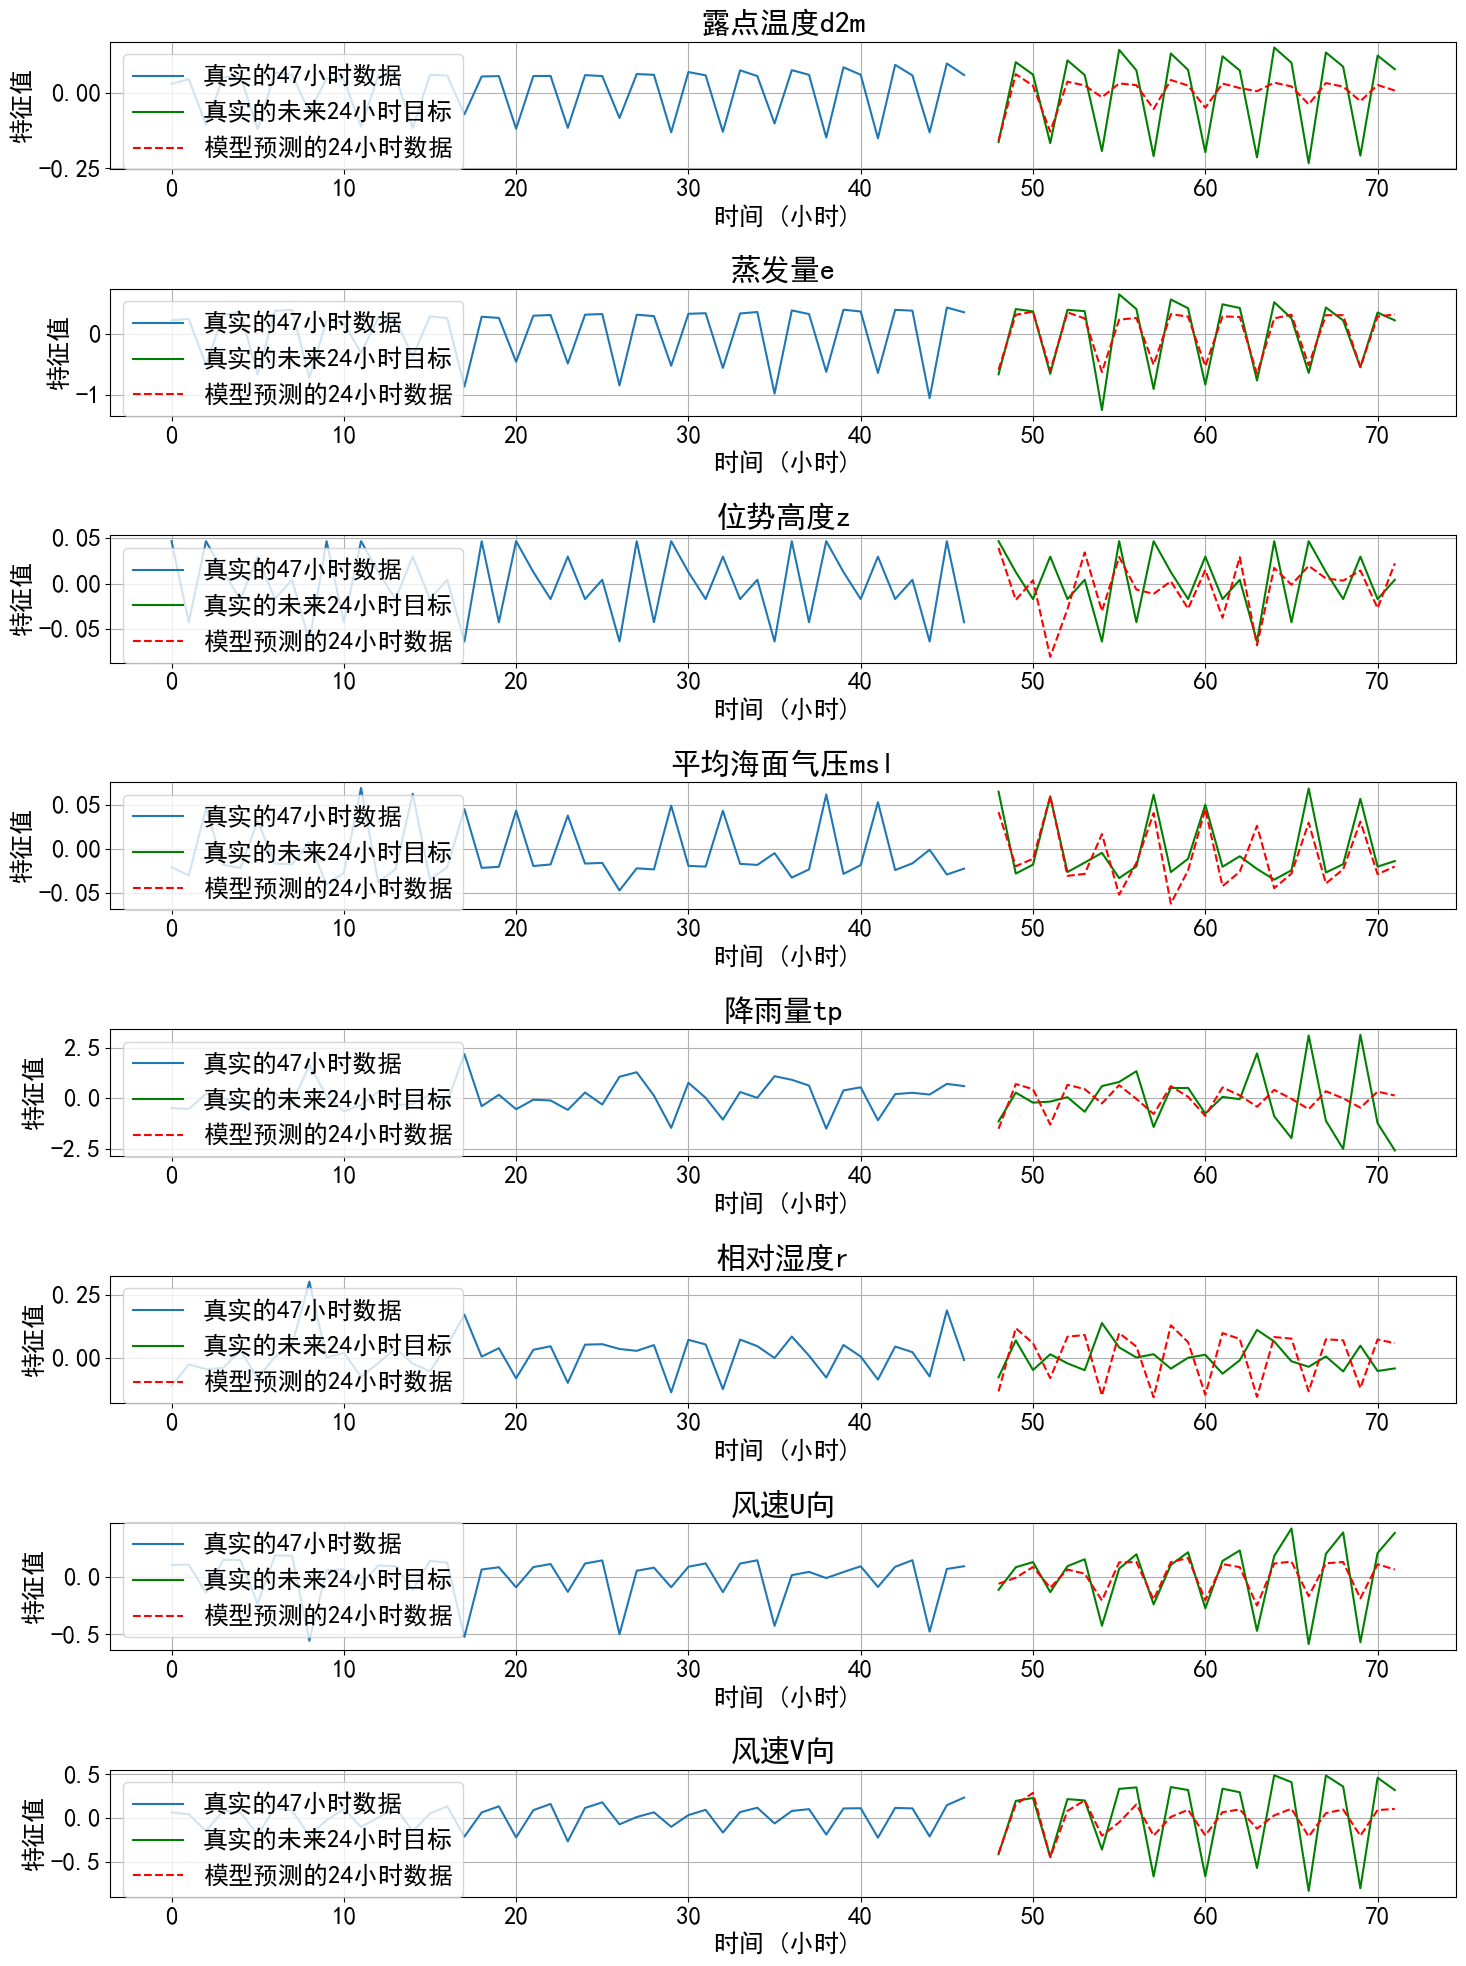

In [9]:
Num_Feature = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
variable_names = ['露点温度d2m', '蒸发量e','位势高度z','平均海面气压msl', '降雨量tp','相对湿度r','风速U向','风速V向']
def evaluate_and_plot_features(model, test_loader):
    for batch in test_loader:
        inputs, targets = batch
        model = model.to(device)
        inputs = inputs.to(device)
        output = model(inputs)
        # 选择第一个样本
        single_input = inputs[0:1].to(device)
        single_target = targets[0:1].to(device)
        output = output[0:1].to(device)
        break  # 只处理第一个batch
    # 将数据移回CPU以便打印或进一步处理
    print(output.shape)

    
    single_input = single_input.cpu().view(-1, Num_Feature)
    single_target = single_target.cpu().view(-1, Num_Feature)
    output = output.cpu().view(-1, Num_Feature)

    # 绘制每个特征的图表
    num_features = Num_Feature
    plt.figure(figsize=(15, 20))
    for i in range(num_features):
        plt.subplot(num_features, 1, i+1)
        plt.plot(single_input[:, i], label='真实的47小时数据')
        plt.plot(range(48, 72), single_target[:, i], 'g', label='真实的未来24小时目标')
        plt.plot(range(48, 72), output[:, i].detach().numpy(), 'r--', label='模型预测的24小时数据')
        plt.title(variable_names[i])
        plt.xlabel('时间 (小时)')
        plt.ylabel(f'特征值')
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

# 调用函数
evaluate_and_plot_features(model, test_loader)